In [1]:
import pandas as pd
import numpy as np
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.utils import *
from sklearn.preprocessing import *

trainingSensor = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")
validationSensor = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")

trainingFood = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
validationFood = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")

In [2]:
trainingSensor["mea_dt"] = trainingSensor["mea_dt"].apply(str)
trainingSensor["mea_dt"]  = trainingSensor["mea_dt"].str.slice(start=0, stop=15)
trainingFood['feed_dt'] = pd.to_datetime(trainingFood['feed_dt'], format='%Y%m%d%H%M', errors='raise')
trainingFood["feed_dt"]=trainingFood["feed_dt"].apply(str)
trainingFood["feed_dt"]  = trainingFood["feed_dt"].str.slice(start=0, stop=15)

validationSensor["mea_dt"] = validationSensor["mea_dt"].apply(str)
validationSensor["mea_dt"]  = validationSensor["mea_dt"].str.slice(start=0, stop=15)
validationFood['feed_dt'] = pd.to_datetime(validationFood['feed_dt'], format='%Y%m%d%H%M', errors='raise')
validationFood["feed_dt"] = validationFood["feed_dt"].apply(str)
validationFood["feed_dt"] = validationFood["feed_dt"].str.slice(start=0, stop=15)

In [3]:
training = pd.merge(left = trainingSensor, right = trainingFood, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
validation = pd.merge(left = validationSensor, right = validationFood, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
validation_oneday = pd.merge(left = validationSensor, right = validationFood, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

In [4]:
training = training[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
validation = validation[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
training = training.fillna(0)
validation = validation.fillna(0)

In [5]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
std_scaler.fit(training)
x_train_t = std_scaler.transform(training)
training = pd.DataFrame(x_train_t, columns=training.columns, index=list(training.index.values))

In [6]:
x_train = training[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
y_train = training[['do_mg']]
x_test = validation[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
y_test = validation[['do_mg']]

In [7]:
x_train = np.asarray(x_train, dtype=np.float64)
x_test = np.asarray(x_test, dtype=np.float64)

In [8]:
x_train = x_train.reshape((-1, 1, 8))
x_test = x_test.reshape((-1, 1, 8))

In [9]:
# shape확인
nCar = x_train.shape[0] # 데이터 개수
nVar = x_train.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_train.shape[0] # 데이터 개수
nVar = y_train.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = x_test.shape[0] # 데이터 개수
nVar = x_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1


In [10]:
from keras import backend as K
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [11]:
model = Sequential()
model.add(LSTM(128, input_shape=(1, 8), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='linear'))
 
model.summary()
 
# 3. 실행
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

2023-04-03 10:38:12.800777: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 10:38:13.221204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            70144     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 132,001
Trainable params: 132,001
Non-trainable params: 0
_________________________________________________________________


In [12]:
hist = model.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data=(x_test, y_test))

2023-04-03 10:38:14.150014: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-04-03 10:38:17.816068: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-04-03 10:38:18.727366: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


34805/34805 [==============================] - 572s 16ms/step - loss: 0.4858 - mae: 0.5313 - r_squared: 0.4753 - val_loss: 33.8248 - val_mae: 5.4472 - val_r_squared: -78.3727
Epoch 2/50
34805/34805 [==============================] - 566s 16ms/step - loss: 0.3439 - mae: 0.4316 - r_squared: 0.6254 - val_loss: 36.4507 - val_mae: 5.6790 - val_r_squared: -84.5318
Epoch 3/50
34805/34805 [==============================] - 566s 16ms/step - loss: 0.2811 - mae: 0.3802 - r_squared: 0.6930 - val_loss: 35.5346 - val_mae: 5.6201 - val_r_squared: -82.0302
Epoch 4/50
34805/34805 [==============================] - 566s 16ms/step - loss: 0.2500 - mae: 0.3530 - r_squared: 0.7267 - val_loss: 35.8274 - val_mae: 5.6014 - val_r_squared: -83.3521
Epoch 5/50
34805/34805 [==============================] - 567s 16ms/step - loss: 0.2318 - mae: 0.3360 - r_squared: 0.7466 - val_loss: 34.7854 - val_mae: 5.5083 - val_r_squared: -81.9802
Epoch 6/50
34805/34805 [==============================] - 567s 16ms/step - loss: 

Epoch 45/50
34805/34805 [==============================] - 623s 18ms/step - loss: 0.1465 - mae: 0.2504 - r_squared: 0.8391 - val_loss: 37.8396 - val_mae: 5.7404 - val_r_squared: -92.3819
Epoch 46/50
34805/34805 [==============================] - 625s 18ms/step - loss: 0.1460 - mae: 0.2498 - r_squared: 0.8398 - val_loss: 38.4102 - val_mae: 5.8070 - val_r_squared: -91.3557
Epoch 47/50
34805/34805 [==============================] - 621s 18ms/step - loss: 0.1457 - mae: 0.2495 - r_squared: 0.8399 - val_loss: 36.1208 - val_mae: 5.6131 - val_r_squared: -87.1424
Epoch 48/50
34805/34805 [==============================] - 617s 18ms/step - loss: 0.1450 - mae: 0.2489 - r_squared: 0.8408 - val_loss: 39.5723 - val_mae: 5.8817 - val_r_squared: -96.5849
Epoch 49/50
34805/34805 [==============================] - 615s 18ms/step - loss: 0.1446 - mae: 0.2484 - r_squared: 0.8415 - val_loss: 38.4341 - val_mae: 5.8108 - val_r_squared: -90.1861
Epoch 50/50
34805/34805 [==============================] - 625s 1

In [13]:
model.save('lstmJaponica4.h5')

In [14]:
pred = model.predict(x_test)

pred.shape

(1113748, 1)

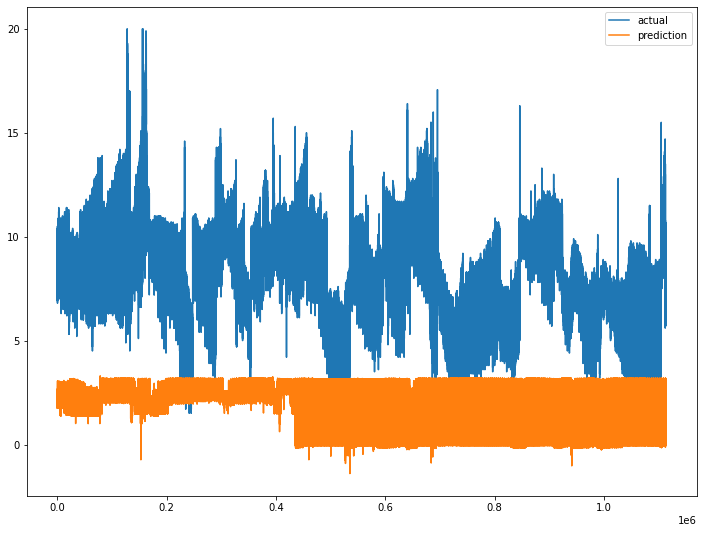

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

[[-1.2664568  -1.4282112  -2.4017136  ...  2.067425    0.7731768
  -0.42515227]
 [-1.1070714  -0.8069595   1.2246329  ... -2.0592782   2.4291377
   0.2225754 ]
 [ 1.6419111  -2.4213028  -0.51305324 ... -0.9504021  -1.6035591
   1.1066236 ]
 ...
 [-0.60238993 -3.432236   -0.6919686  ... -0.23364532 -0.99720955
   0.426759  ]
 [ 1.0465183  -1.1800046  -1.1154777  ... -1.5251622  -0.33169958
  -1.8917707 ]
 [ 0.88341826 -1.1148164  -0.97365654 ... -1.4305133  -0.3959682
  -1.8975545 ]]


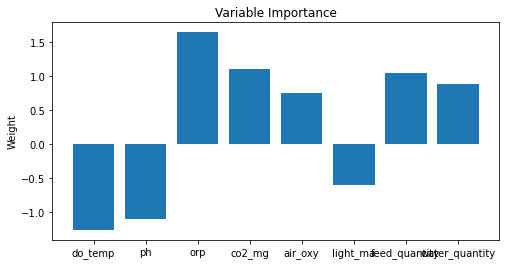

In [16]:
weights = model.layers[0].get_weights()[0]
print(weights)

import matplotlib.pyplot as plt

# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(8), weights[:, 0])
ax.set_xticks(range(8))
ax.set_xticklabels(['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [17]:
from keras.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score


# 평가
mse = model.evaluate(x_test, y_test)
mae = mean_absolute_error(y_test, pred)
r_squared = r2_score(y_test, pred)


print("MSE: ", mse)
print("MAE: ", mae)
print('R-squared:', r_squared)

34805/34805 [==============================] - 238s 7ms/step - loss: 39.6117 - mae: 5.8884 - r_squared: -96.0965
MSE:  [39.61165237426758, 5.88842248916626, -96.09654235839844]
MAE:  tf.Tensor([6.6556664 5.55165   5.558264  ... 6.9992485 8.645226  7.7913837], shape=(1113748,), dtype=float32)
R-squared: -7.826555598532769


In [18]:
oneday = validation_oneday[(validation_oneday['mea_dt'].str.contains('2021-07-21'))&(validation_oneday['tank_id']==1)]
#oneday = validation_oneday[(validation.loc[:'2021-08-09 16:3'])&(validation['tank_id']==1)]
oneday = oneday.fillna(0)
x_test_oneday = oneday[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
y_test_oneday = oneday[['do_mg']]

x_test_oneday = np.asarray(x_test_oneday, dtype=np.float64)
x_test_oneday = x_test_oneday.reshape((-1, 1, 8))

# shape확인
nCar = x_test_oneday.shape[0] # 데이터 개수
nVar = x_test_oneday.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_oneday.shape[0] # 데이터 개수
nVar = y_test_oneday.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 1
nCar: 1440 nVar: 1


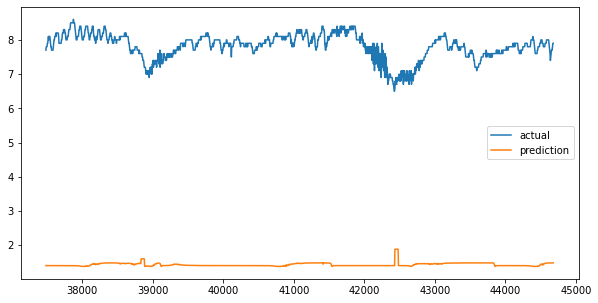

In [19]:
pred_oneday = model.predict(x_test_oneday)
plt.figure(figsize=(10, 5))
plt.plot(oneday.index, y_test_oneday, label = 'actual')
plt.plot(oneday.index, pred_oneday, label = 'prediction')
plt.legend()
plt.show()